# Tutorial 3 - Introduction to Tensorflow and Keras

In the lectures, so far you have covered foundations of neural networks, which include training of deep learning models, overfitting in neural networks and model tuning. Therefore, in today's notebook we will revisit the training of neural networks with two libraries, i.e., Tensorflow and Keras. Tensorflow is among the most popular and powerful deep learning frameworks, which offers great flexibility for model development from scratch. While Tensorflow offers complete control over deep customization, Keras represents the high-level API of the platform of Tensorflow. Keras is a multi-framework deep learning API, which is compatible with PyTorch and jax in addition to Tensorflow. Overall, Keras' API is very easy to use, and thus, model implementation with Keras is less challenging than with Tensorflow. This comes at the cost of less control over the deep learning model implementation. Since both libraries have their advantages and disadvantages, in today's tutorial we will cover both.

Here is the outline of today's notebook:
*   Brief introduction of a new house pricing dataset. 
*   Deep neural network training with Tensorflow (Demo). 
*   Implementation of deep neural networks using Keras (Exercise 1).
*   Tuning of deep neural networks using Keras tuner (Exercise 2).

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras
import keras_tuner

## **1. Ames House Pricing Dataset**

In this excercise session, we will work with a new house pricing dataset, in which each data sample is related to a single house in Ames, Iowa in the USA. Each property is characterized by 17 features. The latter provide information about the following:
| Variable | Description |
|---|---|
| LotFrontage | Linear feet of street connected to property |
| MasVnrArea | Masonry veneer area in square feet |
| BsmtFinSF1 | Square feet of basement that has been finished to a high standard, <br>often suitable for living quarters like a bedroom or a living area.|
| TotalBsmtSF | Total square feet of basement area |
| 1stFlrSF | First Floor square feet |
| 2ndFlrSF | Second Floor square feet |
| GrLivArea | Above grade (ground) living area square feet |
| FullBath |  Number of bathrooms in the main part of the house |
| TotRmsAbvGrd | Number of rooms of main house part, excl. bathrooms |
| Fireplaces | Number of fireplaces |
| GarageCars | Size of garage in car capacity |
| GarageArea | Size of garage in square feet |
| WoodDeckSF | Wood deck area in square feet |  
| OpenPorchSF | Open porch area in square feet |
| YearsSinceBuilt | Number of Years since the house was built |
| YearsSinceRemodling | Number of years since last house remodeling |
| YearsSincegarageBuilt | Number of years since garage was built |  

The SalePrice feature in the data is our target variable, i.e., the sale price of each property in dollars. 


In [10]:
#Import the Ames house prices dataset file from github:
house_prices=pd.read_csv('https://raw.githubusercontent.com/Humboldt-WI/delta/refs/heads/master/tutorial_notebooks/House_Prices_Ames.csv',header=0,sep=',',index_col=0)
house_prices.head(5)

,LotFrontage,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,YearsSinceBuilt,YearsSinceRemodeling,YearsSincegarageBuilt
0,65.0,196.0,706,856,856,854,1710,2,8,0,2,548,0,61,208500,22,22,22.0
1,80.0,0.0,978,1262,1262,0,1262,2,6,1,2,460,298,0,181500,49,49,49.0
2,68.0,162.0,486,920,920,866,1786,2,6,1,2,608,0,42,223500,24,23,24.0
3,60.0,0.0,216,756,961,756,1717,1,7,1,3,642,0,35,140000,110,55,27.0
4,84.0,350.0,655,1145,1145,1053,2198,2,9,1,3,836,192,84,250000,25,25,25.0


Before we move on predictive modeling, we will do some EDA on our new dataset. First, let's examine the distribution of our target variable and the correlation of the predictor features with our target.

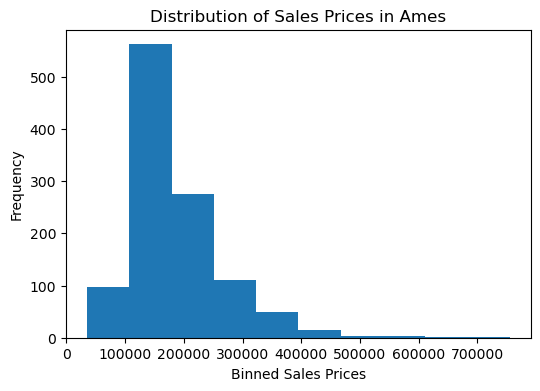

In [11]:
#Distribution of the target variable:
plt.figure(figsize=(6,4))
plt.hist(house_prices['SalePrice'])
plt.xlabel('Binned Sales Prices')
plt.ylabel('Frequency')
plt.title('Distribution of Sales Prices in Ames')
plt.show()
plt.close()

The distribution of the house prices is right-skewed with long tails on the right side indicating that only a few houses have a sale price of higher than $500,000–$600,000.

In [4]:
# Correlations with the target varibale:
house_prices.corr('pearson')[['SalePrice']].drop(['SalePrice'],axis=0).T

,LotFrontage,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,YearsSinceBuilt,YearsSinceRemodeling,YearsSincegarageBuilt
SalePrice,0.34427,0.488658,0.390301,0.615612,0.607969,0.306879,0.705154,0.566627,0.547067,0.461873,0.647034,0.61933,0.336855,0.343354,-0.525394,-0.521253,-0.504753


The pairwise pearson correlation with the target variable shows that 7 out of 17 features have a correlation lower than +/-50%. A low linear pairwise correlation with the target variable does not necessarily mean that these 7 features are completely useless, as these variables might hold predictive power, e.g., in combination with the remaining features. Nonetheless, a low correlation with the target is a good indication that we might have to consider applying regularization techniques during the model training phase to prevent the model from learning information, which could potentially be unnecessary. Next, we will examine the descriptive statistics of the variables in our dataset:

In [5]:
house_prices.describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,YearsSinceBuilt,YearsSinceRemodeling,YearsSincegarageBuilt
count,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,70.665477,108.487957,438.399643,1077.115076,1173.584300,353.258698,1531.411240,1.580731,6.576271,0.603925,1.878680,502.955397,92.610169,46.130241,185506.152542,52.735058,39.316682,46.600357
std,24.266812,189.500966,468.385038,445.656500,386.174253,438.561788,523.723899,0.550117,1.591195,0.632556,0.654313,191.243043,121.868623,64.390029,82999.159004,30.967730,21.025974,25.822833
min,21.000000,0.000000,0.000000,0.000000,438.000000,0.000000,438.000000,0.000000,3.000000,0.000000,1.000000,160.000000,0.000000,0.000000,35311.000000,15.000000,15.000000,15.000000
25%,60.000000,0.000000,0.000000,803.000000,894.000000,0.000000,1155.000000,1.000000,5.000000,0.000000,1.000000,360.000000,0.000000,0.000000,131000.000000,22.000000,20.000000,22.000000
50%,70.000000,0.000000,374.000000,1008.000000,1097.000000,0.000000,1479.000000,2.000000,6.000000,1.000000,2.000000,484.000000,0.000000,27.000000,164900.000000,51.000000,30.000000,44.000000
75%,80.000000,170.000000,702.000000,1324.000000,1411.000000,728.000000,1776.000000,2.000000,7.000000,1.000000,2.000000,600.000000,168.000000,68.000000,219500.000000,72.000000,59.000000,66.000000
max,313.000000,1600.000000,5644.000000,6110.000000,4692.000000,2065.000000,5642.000000,3.000000,12.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,755000.000000,145.000000,75.000000,125.000000


Since there is a significant variation in the mean and the standard deviation of the features, we will rescale our dataset to avoid the model ignoring features with a narrow range of input values during the training process. We will also standardize our target variable, as otherwise we might face the problem of exploding loss values, which would lead to large gradients. The latter would in turn destabilize the training process. 

In [6]:
# First we split the whole dataset into train and test with the ratio 80:20.
x,y=house_prices.drop(['SalePrice'],axis=1),house_prices[['SalePrice']]
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=553)
x_train, y_train, x_test, y_test=x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)


#Then, we reserve the last 246 samples from the train subset for validation purposes: 
x_train,x_val=x_train.iloc[:650,:],x_train.iloc[650:,:]
y_train,y_val=y_train.iloc[:650],y_train.iloc[650:]


#Rescale the datasets:
scaler=StandardScaler()
x_train_rescaled=scaler.fit_transform(x_train)
x_val_rescaled=scaler.transform(x_val)
x_test_rescaled=scaler.transform(x_test)

target_scaler=StandardScaler()
y_train_rescaled=target_scaler.fit_transform(y_train)
y_val_rescaled=target_scaler.transform(y_val)
y_test_rescaled=target_scaler.transform(y_test)

## **2. Deep Neural Network Training with Tensorflow** (DEMO)

First, let's revisit the mains steps of the training process of deep neural networks, using the below illustration: <br>

<img src="https://github.com/Humboldt-WI/demopy/raw/main/Training_Neural_Networks.PNG" width="1150" height="620" alt="Neural Network Training">

Before the model training begins, the initialization of the trainable weights takes place. In the above visualization, the trainable weights are drawn from standard normal distribution. However, drawing weights from this distribution, when building very deep networks with specific nonlinear activation functions can cause problems during the training process. For instance, with bounded activations, e.g., tanh and sigmoid, high negative or positive values get squashed to the lower and upper bound, i.e., the neuron values saturate. When saturated, activations kill the gradients as the flat regions of bounded activations receive gradients close to 0.0. The higher the percentage of saturated neurons, the less the neural network is learning during the training process. In most cases, when drawing random values from a standard normal distribution, the minimum and maximum range of the sampled values is in [-3.5,+3.5]. In case of tanh, input values in the range [-2.2,-3] and [+2.2,+3] end up in the saturation regions. Thus, drawing weights from standard normal distribution is not ideal as it produces values with rather high magnitude for model initialization purposes!. Research studies dealing with initialization methods for neural networks have come to the following conclusions:<br>
- for **bounded activations**: use **Xavier weight initialization**, or also called glorot_normal or glorot_uniform in Tensorflow and Keras. This type of initialization techniques takes into account the number of inputs to and outputs of each hidden layer. (https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)<br>
- for **activations with an open upper bound**: use **Kaiming initialization** method, or also called he_normal or he_uniform in Tensorflow and Keras. This type of initialization techniques takes into account the number of inputs to a hidden layer. (https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf)<br>      

Once the trainable variables have been initialized according to the chosen nonlinearity, the model training can be performed. In the above visualization, we can see that the training of neural networks consists of mainly 4 steps. Conceptually, the most challenging part is related to the computation of the gradients. Luckily, in the second step, one could use GradientTape in Tensorflow, a mathematical tool for automatic differentiation. When training neural networks we use mini-batch gradient descent, i.e., we split the data into mini-batches of certain sample size. We loop through the list of mini-batches and compute the gradients w.r.t. to the loss, that each mini-batch of data produces in a training iteration. Alternatives to mini-batch gradient descent are batch and stochastic gradient descent. The former computes gradients on the loss produced by all training samples, and is therefore very costly, whereas the latter updates the network weights based on the computations performed using a single data sample. The main disadvantage of stochastic gradient descent is that the gradients are very noisy, i.e., a single data sample does not guarantee the accurate approximation of the gradients for the whole network. For this reason, we stick to mini-batch gradient descent. It facilitates more accurate gradient approximation than stochastic gradient descent, and is less costly to compute than batch gradient descent.

In [7]:
batch_size=32

#Splitting train and test dataset into mini-batches:
tf_train_rescaled=tf.data.Dataset.from_tensor_slices((x_train_rescaled,y_train_rescaled)).batch(batch_size)
tf_val_rescaled=tf.data.Dataset.from_tensor_slices((x_val_rescaled,y_val_rescaled)).batch(batch_size)
tf_test_rescaled=tf.data.Dataset.from_tensor_slices((x_test_rescaled,y_test_rescaled)).batch(batch_size)

As we already know from the lecture, regularization techniques help us in preventing overfitting. The latter occurs when, e.g., the model captures non-generalizable information in the input features in the train set. Additionally, overfitting could occur when applying a neural network with high capacity, i.e., a deep neural network consisting of several hidden layers with many units, on a dataset with small sample size. Then, the model is simply too complex for the provided data. In such cases, when implementing neural networks, we could benefit from regularization techniques. In the previous exercise session, we made use of L2 regularization. The lecture also introduced you to dropout-based regularization, which we can revisit using the below illustration:

<img src="https://github.com/Humboldt-WI/demopy/raw/main/Dropouts.PNG" width="1000" height="650" alt="Dropouts">

During the forward pass, a specific percentage of neurons, i.e., $p$, are masked with 0.0s, which leads to deactivating the entire neural path from the dropped out nodes to the output layer. During the backward pass, the corresponding weights do not receive gradients. This prevents the network from learning patterns, which are very specific to the training dataset. Also, dropout regularization prevents the network from relying on a specific node, as the neurons to deactivate with the probability $p$ are randomly chosen during each forward pass with a mini-batch of data. While we benefit from the stochastic nature of dropout-based regularization during training time, during testing time we multiply the already trained weights with $p$ in order to get deterministic outputs. Otherwise, every time we apply our model on the same test dataset, we would get slightly different results.<br>

Now that we have revisited dropout-based regularization, we will create the functions for building Tensorflow models (using dropouts) and for training the initialized models with GradientTape. Afterward, we will perform the model training by looping through our mini-batches for a pre-determined number of epochs. Concerning the latter, we never know the optimal number of epochs to train our model so that it fits the data well without overfitting. For this reason, it is a common practice to apply early stopping callback on your validation set. This callback terminates the training once no improvement can be observed on the validation subset for several epochs. Once the early stopping callback gets activated and the training is terminated, we will visualize the training vs. the validation loss, in order to examine the model fit.

In [8]:
def build_tf_model(nr_input_features:int,
                   list_units:list,
                   dropout_rate:float,
                   activation:str)->tf.keras.Model:
    ''''
    Cerate a (deep) feedforward neural network using the vanilla Dense layers in tensorflow..

    Parameters:
    -----------
    nr_input_features:int
        The number of predictor variables, which is important for the initialization of the weights in the first hidden layer.
    list_units:list
        A list containing the number of hidden units per layer. The length of this list determines the depth of the network.
    dropout_rate: float
        The ratio of neurons, which will be stochastically deactivated during the forward pass.
    activation: str
        The nonlinearity to apply in each hidden layer.


    Returns:
    --------
    tf_model: tf.keras.Model
        The initialized tensorflow feedforwar neural network.
    '''

    input_layer=tf.keras.layers.Input(nr_input_features)
    hidden_output=input_layer
    for hidden_layer_idx in range(0,len(list_units)):
        
        hidden_output=tf.keras.layers.Dense(units=list_units[hidden_layer_idx],activation=activation,
        kernel_initializer=(tf.keras.initializers.HeNormal() if activation=='ReLU' else tf.keras.initializers.GlorotNormal()) )( (input_layer if hidden_layer_idx==0 else hidden_output) )
        hidden_output=tf.keras.layers.Dropout(dropout_rate)(hidden_output)

    prediction_layer_outputs=tf.keras.layers.Dense(units=1,activation='linear')(hidden_output)

    tf_model=tf.keras.Model(inputs=input_layer,outputs=prediction_layer_outputs)

    return tf_model

def train_test_model(training:bool,
                    model:tf.keras.Model,
                    x_batch_data:tf.Tensor,
                    y_batch_data:tf.Tensor,
                    optimizer:None = None)->tf.Tensor:
    '''
    Trains a (deep) feedforward neural network using the automated differentiation functionality supported by GradientTape.

    Parameters:
    -----------
    training:bool
        Whether we are training or testing the model.
    model:tf.keras.Model
        The feedforward neural network.
    x_batch_data: tf.Tensor
        The ratio of neurons, which will be stochastically deactivated during the forward pass.
    y_batch_data: tf.Tensor
        The ratio of neurons, which will be stochastically deactivated during the forward pass.
    optimizer: None
        The optimizer used during the training process. Since during testing time, we do not need it, the parameters has the input type None.
        During training time, parameter would be of the type tf.keras.optimizers.Optimizer.


    Returns:
    --------
    current_batch_loss: tf.Tensor
        The initialized tensorflow feedforwar neural network.
    '''

    if training==True:
        with tf.GradientTape() as tape:
            predictions_train=model(x_batch_data,training=True)
            current_batch_loss=tf.keras.losses.MSE(y_pred=tf.squeeze(predictions_train,axis=-1),y_true=tf.squeeze(y_batch_data,axis=-1))
        gradients=tape.gradient(current_batch_loss,model.trainable_variables)#compute weight updates for backward pass
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))#apply computed gradients
        
    else:
        predictions_test=model(x_batch_data,training=False)
        current_batch_loss=tf.keras.losses.MSE(y_pred=tf.squeeze(predictions_test,axis=-1),y_true=tf.squeeze(y_batch_data,axis=-1))
        
    return current_batch_loss

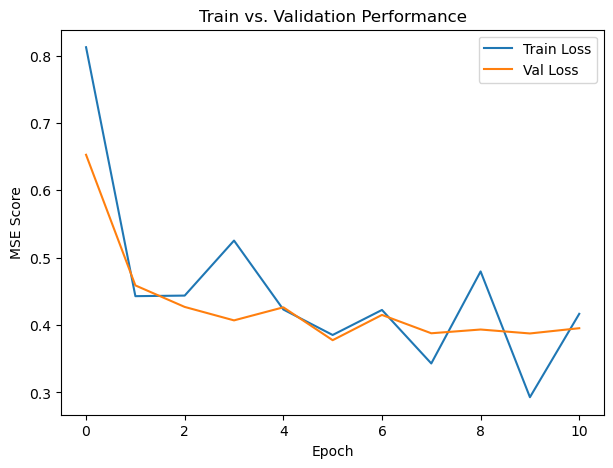

In [71]:
#Create the model:
tf_model=build_tf_model(nr_input_features=x_train.shape[1],
                        list_units=[100,50,10],dropout_rate=0.3,
                        activation='relu')

#Initialize the optimizer: 
#A very common choice nowadays for an optimizer is Adam, which supports the functionality of an adaptive learning rates. 
# The default choice for the initial learning rate in Adam is 0.001, which works for most applications. 
# Unless you plan to define a range of possible values for the learning rate to tune this hyperparameter, we suggest you go with the default choice. 
tf_optimizer=tf.keras.optimizers.Adam()


#Train and test the model:
train_loss_list=[]
val_loss_list=[]
nr_epochs=100

#Early stopping callback:
patience = 5
wait = 0
#We would like to minimize our loss, thus we set the initial best value to inf+
best = float('inf')

for epoch in range(0,nr_epochs):
    epoch_train_loss=[]
    epoch_val_loss=[]
    #Predictions on Train Set:
    for batch_idx,(x_batch_train,y_batch_train) in enumerate(tf_train_rescaled):
        train_loss=train_test_model(training=True,
                    model=tf_model,
                    x_batch_data=x_batch_train,
                    y_batch_data=y_batch_train,
                    optimizer=tf_optimizer)
        epoch_train_loss.append(train_loss.numpy())
        
    train_loss_list.append(np.mean(epoch_train_loss))

    #Predictions on train set:
    for batch_idx,(x_batch_val,y_batch_val) in enumerate(tf_val_rescaled):
        val_batch_loss=train_test_model(training=False,
                    model=tf_model,
                    x_batch_data=x_batch_val,
                    y_batch_data=y_batch_val)

        epoch_val_loss.append(val_batch_loss.numpy())
    
    epoch_val_loss=np.mean(epoch_val_loss)
    val_loss_list.append(epoch_val_loss)

    #Early stopping callback:
    wait += 1
    if epoch_val_loss < best:
      best = epoch_val_loss
      wait = 0
    if wait >= patience:
      break
    
# Visualize the model performance:
plt.figure(figsize=(7,5))
plt.plot(train_loss_list,label='Train Loss')
plt.plot(val_loss_list,label='Val Loss')
plt.ylabel('MSE Score')
plt.xlabel('Epoch')
plt.title('Train vs. Validation Performance')
plt.legend()
plt.show()
plt.close()
  
            

While we set the maximum number of epochs to 100, we need no more than 10-30 epochs. The number of the exact epoch, when the training process is stopped, can vary slightly, when you make multiple runs. Thus, if you execute the above code cell several times, the train vs. validation performance plot would look slightly different after each run. Overall, once the early stopping callback is activated, it terminates the training process to prevent us from fitting the model too well on the training subset. In this way, we reduce the risk of overfitting, and we also reduce the number of training epochs significantly in comparison to the maximum number of epochs we defined before the training process.

In [73]:
test_pr=tf_model.predict(x_test_rescaled,verbose=0)
print('Test MSE achieved by not tuned Tensorflow Model built with the functioanl API: ',round(mean_squared_error(y_true=y_test_rescaled.flatten(),
                                                                                y_pred=test_pr.flatten()),5) )

Test MSE achieved by not tuned Tensorflow Model built with the functioanl API:  0.31453


##### **Demo Summary:**<br>
- when building neural networks with the functional API, we create a Tensorflow model consisting of an input layer, a hidden layer (or several hidden layers) and a prediction layer. Every following layer takes the outputs from the previous layer, which leads to adding every following layer to the Tensorflow model. The equivalent to this using the sequential API is model.add(new layer). When adding a new hidden layer, we initialize its weights based on the chosen nonlinearity.
- training neural networks with the functional API implies encoding the four main steps of the learning process manually: 1) compute the forward pass, 2) compute the loss and compute the gradients, 3) update network parameters, and 4) check the stopping criterion. The equivalent to this with the sequential API is very simple: we use model.fit(...) to execute the four main steps of the training process on the background.
- we often apply regularization techniques to prevent our models from overfitting, e.g., l1 or l2 regularization, dropouts, early stopping callback, etc.
- once the training process is completed, we examine the model fit by plotting the training vs. the validation loss for all epochs, which the models has gone through. 

## **2. Implementation of deep Neural Networks using Keras.** <br>(Excercise 1)

In this section, you will use the same rescaled train and validation subsets from the demo when fitting a Keras model implemented with the sequential API. The following link shows an example how to use the sequential API: https://keras.io/api/models/sequential/. Your first task includes the following: <br>
- build the same network as in the demo part of this notebook, but with the sequential API, i.e., a feedforward neural network with 3 ReLU-based hidden layers each having 100, 50 and 10 neurons. <br> 
Since you will be using ReLU in the hidden layers, make sure you initialize the trainable variables with the Kaiming initialization method. After each hidden layer, you should apply a dropout of 30%. 
- the optimizer should be Adam with the default settings, and the loss function should be MSE. 
- also, make use of early stopping callback on the validation loss with patience=5 epochs (https://keras.io/api/callbacks/early_stopping/). 
- set the batch size to 32, and fit the model for a maximum of 100 epochs. Save the training history in the variable 'model_training_history' for visualization purposes.<br> 
- so far we have created several well-documented functions. Thus, put the code from the demo which generates the train vs. validation performance plot in a well-documented function, which you can call multiple times instead of always copy-pasting the code for the performance visualization.
- save the test predictions from the not-tuned model in the variable 'test_pr', which you will use in the third exercise to compare the performance on the test set with hyperparameter tuning. At the end of this exercise print out the MSE error on the test set.

In [ ]:
#Define your early stopping callback:
...

#Your keras model using the sequential api:
model=...

#Train your model:
model_training_history=model.fit(...) 

In [ ]:
#Create a function for visualize the model performance which takes as inputs the train_loss_list val_loss_list:
def visualize_performance(...)->...:
    '''
    ...

    Parameters:
    -----------
    ...
    
    ...
    
    

    Returns: ...
    '''

#Visualize the performance by calling the function.
#You can access the training history by calling model_training_history.history...
train_loss=model_training_history.history['loss']
val_loss=model_training_history.history['val_loss']

visualize_performance(train_loss_list=train_loss,
                      val_loss_list=val_loss)


In [ ]:
test_pr=model.predict(...)
print('Test MSE achieved by not tuned Keras Sequential Model: ',...)

## **3. Tuning of deep Neural Networks using Keras Tuner.** <br>(Excercise 2)
In this section, you will use use the package keras_tuner to tune a neural network built with the sequential API. To keep things consistent, the optimization function should search through the same search space, which we considered in the last exercise session, when performing hyperparameter tuning with optuna. The following links provide you with an example how to implement the objective function for keras_tuner, and how to select different types of hyperparameters: https://keras.io/keras_tuner/ and https://keras.io/keras_tuner/api/hyperparameters/. Keras_tuner supports different search algorithms. Your task includes the following points:<br>
- implement random search using keras_tuner with the search space from Exercise 3 in 'DL_Training_and_Tuning_Student.ipynb' notebook. This would involve creating an object of class keras_tuner.RandomSearch(...). The latter should be initialized with the following parameters:<br>
        -  the name of the function, which samples different hyperparameter configurations<br>
        - the objective to minimize, in this case this would be the validation loss<br>
        - the number of maximum trials to run keras_tuner for, e.g., 50<br>
        - the directory, where to store the optimization results, .e.g., "./tmp/checkpoint". <br>
          In case you have not created the directory before the training process in the same folder as the jupyter notebook, then keras_tuner would do this for you automatically.<br>
        - whether to overwrite the results from any previous runs.<br>
         It is advised to set the overwrite parameter to True, so that if you re-run keras_tuner multiple times, each time keras_tuner is reset, unless you would like to consider the results from previous runs.<br>
- when you execute the search, make sure to apply early stopping callback
- extract the best hyperparameter configuration from the search
- save the best performing model discovered during the search
- compare the results on the test set with vs. without tuning using the MSE score. 

In [7]:
def keras_hp_optimization(hp:keras_tuner.HyperParameters)->keras.Sequential:
  '''
    Perform hyperparameter tuning using optuna.

    Parameters:
    -----------
    hp:keras_tuner.HyperParameters
        A set of different types of keras tuner hyperparameters, which can be sampled during the search.

    Returns: 
    ---------
    model: keras.Sequential
        The keras model built with the sequential api and the set of sampled hyperparameters in the current trial.
    '''
    
  #Sample the type of activation function to apply in each hidden layer:
  current_activation=...
  
  model = ...
  
  #Sample number of neurons for a pre-defined maximum number of hidden layers: 
  # here you need to consider conditional hyperparameters:
  max_hidden_layers=3
  keep_sampling_hidden_units=True
  nr_hidden_layer=0
  
  while keep_sampling_hidden_units:
      if nr_hidden_layer==0:
          current_hidden_units=...
      else:
          current_hidden_units=...
      
      if current_hidden_units==0 or nr_hidden_layer==max_hidden_layers-1:
          ...
      
      if current_hidden_units!=0:
          #then add the hidden layer to the sequential model in keras with the already sampled activation function:
          ...
          
      nr_hidden_layer=nr_hidden_layer+1
  
  #Add the final prediction layer:
  ...

  #Non-conditional hyperparameters:
  current_optimizer=...
  current_learning_rate=...
  
  model.compile(optimizer=...,
                loss='mse')

  return model

In [ ]:
#Create the callback:
es_callback=...
    
tuner = keras_tuner.RandomSearch(...)

#Sample different configurations to explore the search space:
tuner.search(...)

#Get the best model:
best_model =...

In [ ]:
print('Summary of best hyperparameter configuration: \n',...)

In [ ]:
tuned_keras_pr=best_model.predict(...)
print('Test MSE achieved by not tuned Keras Sequential Model: ',...)
print('Test MSE achieved by tuned Keras Sequential Model: ',...)